In [126]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool, cv
import optuna
import warnings
from sklearn.model_selection import KFold
import math

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

import phik # library for PhiK correlation
import missingno # library for displaying gaps in data
import gc # garbage collector

from scipy.spatial.distance import cdist
warnings.filterwarnings("ignore")

In [127]:
class CFG:
    TARGET = ['nivel_y']
    N_FOLDS = 5
    RANDOM_STATE = 3
    TEST_SIZE = 0.2
    VAL_SIZE = 0.2  

    # PATH_TRAIN = './data/ThreeRanges/400600/400-600_CALIB.csv'
    # PATH_TEST = './data/ThreeRanges/400600/400-600_TEST.csv'

    # PATH_TRAIN = './data/ThreeRanges/200400/200-400_CALIB.csv'
    # PATH_TEST = './data/ThreeRanges/200400/200-400_TEST.csv'

    PATH_TRAIN = './data/ThreeRanges/0200/0-200_CALIB.csv'
    PATH_TEST = './data/ThreeRanges/0200/0-200_TEST.csv'
    
    TARGET_SCALER = None  # 'standard', 'minmax', 'log'

In [128]:
class DataAnalysis:
    
    @staticmethod
    def info_df(df: pd.DataFrame) -> None:
        print('------------------------------')
        print('| Dataset information |')
        print('------------------------------')
        df.info()
        print('-----------------------------------------')
        print('| First 5 rows |')
        print('-----------------------------------------')
        display(df.head())
        print('--------------------')
        print('| Sum of duplicates |')
        print('--------------------')
        print(df.duplicated().sum())


    @staticmethod
    def view_distribution(data: pd.DataFrame, object_col = False, numeric_col = False) -> None:
        numeric_cols = data.select_dtypes(exclude=['object', 'datetime']).columns.to_list()
        object_cols = data.select_dtypes(include=['object']).columns.to_list()
        
        if numeric_col:
            _, axes = plt.subplots(nrows=len(data[numeric_cols].columns), ncols=2, figsize=(len(numeric_cols)+25,len(numeric_cols)+14))
            j = 0
            for i in data[numeric_cols].columns:
                sns.histplot(data[numeric_cols][i], ax=axes[j, 0], kde=True, bins=40, edgecolor='black')
                axes[j, 0].set_title(i, fontsize=8)
                axes[j, 0].set_xlabel('')

                sns.boxplot(x=data[numeric_cols][i], ax=axes[j, 1], orient='h', palette='pink')
                axes[j, 1].set_title(i, fontsize=8)
                axes[j, 1].set_xlabel('')
                j += 1
            plt.suptitle(f'Num features\n\n', ha='center', fontweight='bold', fontsize=20);
            plt.tight_layout();
            plt.show();

        if object_col:
            _,ax = plt.subplots(len(object_cols),1, figsize=(len(object_cols)+7,len(object_cols)+20));
            ax =ax.flatten();
            g = 0
            for k in data[object_cols].columns:
                sns.countplot(data=data, x=k,ax=ax[g]);
                ax[g].set_xticklabels(labels=ax[g].get_xticklabels());
                ax[g].set_title(k);
                ax[g].set_xlabel('');
                g += 1
            plt.suptitle(f'Categorical\n\n', ha='center', fontweight='bold', fontsize=20);
            plt.show();


    @staticmethod
    def bloating_of_variance(data: pd.DataFrame) -> None:
        num = data.select_dtypes(exclude=['object', 'datetime']).columns.to_list()
        vif_data = pd.DataFrame()
        vif_data['feature'] = data.select_dtypes(exclude=['object', 'datetime']).columns.to_list()

        vif_data['VIF'] = [variance_inflation_factor(data[num].values, i) \
                                for i in range(len(data[num].columns))]
        print(vif_data)
    
    @staticmethod
    def balance_of_target(data: pd.DataFrame, target: str) -> None:
        sns.countplot(y=target, data=data, color='green', width=0.6);

    @staticmethod
    def plot_count(df: pd.core.frame.DataFrame, col: str, title_name: str='Train') -> None:
        # Set background color
        f, ax = plt.subplots(1, 2, figsize=(16, 7))
        plt.subplots_adjust(wspace=0.2)

        s1 = df[col].value_counts()
        N = len(s1)

        outer_sizes = s1
        inner_sizes = s1/N

        colors = sns.color_palette("mako")
        
        outer_colors = ['#2e1e3b', '#413d7b', '#37659e', '#348fa7', '#40b7ad', '#8bdab2']
        inner_colors = ['#2e1e3b', '#413d7b', '#37659e', '#348fa7', '#40b7ad', '#8bdab2']

        ax[0].pie(
            outer_sizes,colors=outer_colors, 
            labels=s1.index.tolist(), 
            startangle=90, frame=True, radius=1.3, 
            explode=([0.05]*(N-1) + [.3]),
            wedgeprops={'linewidth' : 1, 'edgecolor' : 'black'}, 
            textprops={'fontsize': 12, 'weight': 'bold', 'color': 'white'}
        )

        textprops = {
            'size': 13, 
            'weight': 'bold', 
            'color': 'white'
        }

        ax[0].pie(
            inner_sizes, colors=inner_colors,
            radius=1, startangle=90,
            autopct='%1.f%%', explode=([.1]*(N-1) + [.3]),
            pctdistance=0.8, textprops=textprops
        )

        center_circle = plt.Circle((0,0), .68, color='black', fc='#243139', linewidth=0)
        ax[0].add_artist(center_circle)

        x = s1
        y = s1.index.tolist()
        sns.barplot(
            x=x, y=y, ax=ax[1],
            palette=colors, orient='horizontal'
        )

        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        ax[1].tick_params(
            axis='x',         
            which='both',      
            bottom=False,       
            labelbottom=False
        )

        for i, v in enumerate(s1):
            ax[1].text(v, i+0.1, str(v), color='white', fontweight='bold', fontsize=12)

        plt.setp(ax[1].get_yticklabels(), fontweight="bold")
        plt.setp(ax[1].get_xticklabels(), fontweight="bold")
        ax[1].set_xlabel(col, fontweight="bold", color='white')
        ax[1].set_ylabel('count', fontweight="bold", color='white')

        f.suptitle(f'{title_name}', fontsize=8, fontweight='bold', color='white')
        plt.tight_layout() 
        plt.show()
    
    @staticmethod
    def summary(data: pd.DataFrame) -> None:
        data = data.select_dtypes(exclude=['object', 'datetime'])
        sum = pd.DataFrame(data.dtypes, columns=['dtypes'])
        sum['missing#'] = data.isna().sum()
        sum['missing%'] = (data.isna().sum())/len(data)
        sum['uniques'] = data.nunique().values
        sum['count'] = data.count().values
        sum['skew'] = data.skew().values
        return sum
    
    @staticmethod
    def correlations(data: pd.DataFrame) -> None:
        data = data.drop(columns=CFG.TARGET)
        plt.figure(figsize=(15, 13));
        # Generate a mask for the upper triangle
        mask_pir = np.triu(np.ones_like(data.corr(method='pearson'), dtype=bool));
        mask_spi = np.triu(np.ones_like(data.corr(method='spearman'), dtype=bool));
       
        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(11, 9));

        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True);
        plt.title('PIRSON')
        sns.heatmap(data.corr(method='pearson'), annot=True, mask=mask_pir, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, robust=True);
        plt.show();
        
        plt.figure(figsize=(15, 13));
        f, ax = plt.subplots(figsize=(11, 9));
        plt.title('SPEARMAN')
        sns.heatmap(data.corr(method='spearman'), annot=True, mask=mask_spi, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, robust=True)
        plt.show();

        plt.figure(figsize=(15, 13));
        f, ax = plt.subplots(figsize=(11, 9));
        
        interval_cols = data.select_dtypes(exclude='object').columns.to_list()
        phik_overview = data.phik_matrix(interval_cols=interval_cols)
        plt.title(r'$\phi_K$')
        corr = phik_overview.round(2)
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, mask=mask, cmap='pink_r', vmax=.3, center=0,
                annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

        significance_overview  = data.significance_matrix(interval_cols=interval_cols)

        plt.figure(figsize=(15, 13));
        plt.title('Statistical significance')
        corr = significance_overview.round(2)
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, mask=mask, cmap='pink_r', vmax=5, vmin=-5, center=0,
                annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

        plt.show()
    

In [129]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from typing import Tuple, List

class DataLoader:
    def __init__(self, df: pd.DataFrame, target_cols: List[str] = ['nivel_y']):
        self.df = df.copy()
        self.target_cols = target_cols
        self.X = None
        self.y = None
        self.feature_names_ = []
        self.feature_scaler = StandardScaler()
        self.target_scaler = None

    @staticmethod
    def reduce_mem_usage(dataframe: pd.DataFrame) -> pd.DataFrame:
        """Оптимизация памяти с пропуском временных и категориальных колонок."""
        start_mem = dataframe.memory_usage().sum() / 1024**2
        print(f"Изначальное использование памяти: {start_mem:.2f} MB")

        for col in dataframe.columns:
            col_type = dataframe[col].dtype
            if str(col_type).startswith('datetime') or str(col_type) == 'category':
                continue

            if col_type != object:
                c_min = dataframe[col].min()
                c_max = dataframe[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        dataframe[col] = dataframe[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        dataframe[col] = dataframe[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        dataframe[col] = dataframe[col].astype(np.int32)
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        dataframe[col] = dataframe[col].astype(np.float32)
                    else:
                        dataframe[col] = dataframe[col].astype(np.float64)
            else:
                dataframe[col] = dataframe[col].astype('category')

        end_mem = dataframe.memory_usage().sum() / 1024**2
        print(f"Итоговое использование памяти: {end_mem:.2f} MB "
              f"(экономия {(start_mem - end_mem) / start_mem * 100:.1f}%)")
        return dataframe

    def _detect_time_series_cols(self) -> pd.DataFrame:
        """Автоматически определяет временные ряды как все числовые столбцы до мета-признаков."""
        meta_candidates = self.df.columns[-30:]  # расширенный буфер
        meta_numeric = self.df[meta_candidates].select_dtypes(include=[np.number]).columns
        known_meta = { 'time', 'center_vim_bubble_X', 'center_vim_bubble_Y',
            'method_vim', 'watch_indicator', 'nivel_x', 'nivel_y', 'nivel_t',
            'temperature', 'laser_x', 'laser_y', 'method_laser', 'state_leds',
            'Comment', 'source_file', 'brig_mean', 'centroid_x_brig',
            'centroid_y_brig', 'centroid_x', 'centroid_y', 'form_factor',
            'aspect_ratio', 'point_density', 'circularity',
            'bounding_box_diagonal', 'orientation_angle', 'n_points', 'brig_skew'
        }
        meta_cols = [c for c in self.df.columns if c in known_meta or c in meta_numeric]
        ts_cols = [c for c in self.df.columns if c not in meta_cols and pd.api.types.is_numeric_dtype(self.df[c])]
        return self.df[ts_cols]

    def _engineer_time_series_features(self, ts_df: pd.DataFrame) -> pd.DataFrame:
        """Генерация признаков из временных рядов с интерполяцией пропусков."""
        features = pd.DataFrame(index=ts_df.index)

        # === Интерполяция пропусков по строкам ===
        # 1. Интерполируем линейно внутри каждой строки
        # ts_df_interp = ts_df.apply(lambda row: row.interpolate(method='linear'), axis=1)
        
        # # 2. Заполняем оставшиеся NaN на краях (если начало или конец — NaN)
        # ts_df_interp = ts_df_interp.apply(lambda row: row.fillna(method='bfill').fillna(method='ffill'), axis=1)
        
        # 3. Если вся строка была NaN — заполняем нулями (крайне редкий случай)
        ts_df_interp = ts_df.fillna(0.0)

        # # === Генерация признаков ===
        features['ts_mean'] = ts_df_interp.mean(axis=1)
        features['ts_std'] = ts_df_interp.std(axis=1)
        features['ts_min'] = ts_df_interp.min(axis=1)
        features['ts_max'] = ts_df_interp.max(axis=1)
        features['ts_range'] = features['ts_max'] - features['ts_min']
        features['ts_skew'] = ts_df_interp.skew(axis=1)
        features['ts_kurt'] = ts_df_interp.kurtosis(axis=1)
        features['ts_last'] = ts_df_interp.iloc[:, -1]
        features['ts_first'] = ts_df_interp.iloc[:, 0]
        features['ts_diff'] = features['ts_last'] - features['ts_first']
        features['ts_nonzero_ratio'] = (ts_df_interp != 0).mean(axis=1)

        window = min(5, ts_df_interp.shape[1])
        features['ts_rolling_mean'] = ts_df_interp.iloc[:, -window:].mean(axis=1)
        features['ts_rolling_std'] = ts_df_interp.iloc[:, -window:].std(axis=1)

        return features

    def _extract_meta_features(self) -> pd.DataFrame:
        """Извлекает известные мета-признаки, пропуская нечисловые и таргет."""
        all_meta_cols = [
            'center_vim_bubble_X', 'center_vim_bubble_Y',
            'nivel_x', 'nivel_t',
            'temperature',
            'laser_x', 'laser_y',
            'brig_mean', 'centroid_x_brig', 'centroid_y_brig',
            'centroid_x', 'centroid_y',
            'form_factor', 'aspect_ratio', 'point_density',
            'circularity', 'bounding_box_diagonal',
            'orientation_angle', 'n_points', 'brig_skew'
        ]
        # Фильтруем существующие и числовые
        meta_cols = [c for c in all_meta_cols if c in self.df.columns and pd.api.types.is_numeric_dtype(self.df[c])]
        return self.df[meta_cols].fillna(0)

    def load(
        self,
        target_scaler_type: str = None,
        drop_columns: List[str] = None
    ) -> Tuple[pd.DataFrame, pd.Series]:
        """
        Загрузка и обработка данных.

        Parameters:
        - target_scaler_type: тип масштабирования целевой переменной ('standard', 'minmax', 'log', None)
        - drop_columns: список колонок, которые нужно исключить из исходного df перед обработкой
        """
        print(" → Загрузка и обработка данных...")

        # 0. Удаление указанных колонок
        if drop_columns:
            existing_to_drop = [col for col in drop_columns if col in self.df.columns]
            if existing_to_drop:
                print(f" → Удаление колонок: {existing_to_drop}")
                self.df = self.df.drop(columns=existing_to_drop)
            else:
                print(" → Нет колонок для удаления (указаны несуществующие).")

        # 1. Оптимизация памяти
        self.df = self.reduce_mem_usage(self.df)

        # 2. Извлечение y
        if len(self.target_cols) == 1:
            self.y = self.df[self.target_cols[0]].astype(np.float32)
        else:
            self.y = self.df[self.target_cols].astype(np.float32)

        # 3. Извлечение признаков
        ts_df = self._detect_time_series_cols()
        ts_features = self._engineer_time_series_features(ts_df)
        meta_features = self._extract_meta_features()

        self.X = pd.concat([ts_features, meta_features], axis=1)
        self.feature_names_ = self.X.columns.tolist()

        # 4. Масштабирование X
        self.X = pd.DataFrame(
            self.feature_scaler.fit_transform(self.X),
            columns=self.feature_names_,
            index=self.X.index
        )

        # 5. Масштабирование y (опционально)
        if target_scaler_type == 'standard':
            self.target_scaler = StandardScaler()
        elif target_scaler_type == 'minmax':
            self.target_scaler = MinMaxScaler()
        elif target_scaler_type == 'log':
            self.target_scaler = None
            if (self.y <= 0).any():
                print("Отрицательные значения — log-масштабирование невозможно")
            else:
                self.y = np.log1p(self.y)
        else:
            self.target_scaler = None

        if self.target_scaler is not None:
            if len(self.target_cols) == 1:
                self.y = pd.Series(
                    self.target_scaler.fit_transform(self.y.values.reshape(-1, 1)).flatten(),
                    index=self.y.index,
                    name=self.y.name
                )
            else:
                self.y = pd.DataFrame(
                    self.target_scaler.fit_transform(self.y),
                    columns=self.y.columns,
                    index=self.y.index
                )

        print(f" → Целевая переменная: min={self.y.min():.3f}, max={self.y.max():.3f}")
        print(f" → Форма X: {self.X.shape}, форма y: {self.y.shape}")
        print(f" → Признаки ({len(self.feature_names_)}): {self.feature_names_[:10]}...")

        return self.X, self.y

In [130]:
import ast

def expand_array_column(df, col_name, prefix):
    def safe_literal_eval(x):
        if pd.isna(x) or not isinstance(x, str):
            return []
        try:
            return ast.literal_eval(x)
        except:
            return []

    arrays = df[col_name].apply(safe_literal_eval)
    max_len = arrays.apply(len).max()

    # Приведение всех массивов к одинаковой длине (заполнение NaN)
    padded = arrays.apply(lambda arr: arr + [np.nan] * (max_len - len(arr)))
    expanded = pd.DataFrame(padded.tolist(), index=df.index)

    # Имена новых колонок
    expanded.columns = [f"{prefix}_{i}" for i in range(expanded.shape[1])]

    return expanded

In [131]:
def preprocess_raw_csv(path):
    df = pd.read_csv(path, skipinitialspace=True, index_col='index', on_bad_lines='skip')

    df = df.dropna(subset=CFG.TARGET)

    if 'vim_points_brig' in df.columns:
        vim_ts = expand_array_column(df, 'vim_points_brig', 'vim')
        df = df.drop(columns=['vim_points_brig']).join(vim_ts)

    if 'laser_points_brig' in df.columns:
        laser_ts = expand_array_column(df, 'laser_points_brig', 'laser')
        df = df.drop(columns=['laser_points_brig']).join(laser_ts)

    return df

In [132]:
train_df = preprocess_raw_csv(CFG.PATH_TRAIN)
test_df = preprocess_raw_csv(CFG.PATH_TEST)

nivel_conversion = 0.0047
vim_conversion = 0.0015 / nivel_conversion 

# train_df[CFG.TARGET] = train_df[CFG.TARGET] / nivel_conversion
# test_df[CFG.TARGET] = test_df[CFG.TARGET] / nivel_conversion

vim_columns = [
    'center_vim_bubble_X',
    'center_vim_bubble_Y',
    'centroid_x',
    'centroid_y',
]

# Применяем конверсию только к существующим колонкам
for col in vim_columns:
    if col in train_df.columns:
        train_df[col] = train_df[col] / vim_conversion
    if col in test_df.columns:
        test_df[col] = test_df[col] / vim_conversion


train_loader = DataLoader(df=train_df, target_cols=CFG.TARGET)
X_train, y_train = train_loader.load(target_scaler_type=CFG.TARGET_SCALER, drop_columns=['brig_mean', 'laser_x', 'laser_y'])

test_loader = DataLoader(df=test_df, target_cols=CFG.TARGET)
X_test, y_test = test_loader.load(target_scaler_type=CFG.TARGET_SCALER, drop_columns=['brig_mean', 'laser_x', 'laser_y'])

 → Загрузка и обработка данных...
 → Удаление колонок: ['brig_mean', 'laser_x', 'laser_y']
Изначальное использование памяти: 11.80 MB
Итоговое использование памяти: 5.95 MB (экономия 49.5%)
 → Целевая переменная: min=-310.638, max=-78.723
 → Форма X: (419, 30), форма y: (419,)
 → Признаки (30): ['ts_mean', 'ts_std', 'ts_min', 'ts_max', 'ts_range', 'ts_skew', 'ts_kurt', 'ts_last', 'ts_first', 'ts_diff']...
 → Загрузка и обработка данных...
 → Удаление колонок: ['brig_mean', 'laser_x', 'laser_y']
Изначальное использование памяти: 9.45 MB
Итоговое использование памяти: 4.75 MB (экономия 49.7%)
 → Целевая переменная: min=-297.872, max=-80.851
 → Форма X: (294, 30), форма y: (294,)
 → Признаки (30): ['ts_mean', 'ts_std', 'ts_min', 'ts_max', 'ts_range', 'ts_skew', 'ts_kurt', 'ts_last', 'ts_first', 'ts_diff']...


In [133]:
X_train.columns

Index(['ts_mean', 'ts_std', 'ts_min', 'ts_max', 'ts_range', 'ts_skew',
       'ts_kurt', 'ts_last', 'ts_first', 'ts_diff', 'ts_nonzero_ratio',
       'ts_rolling_mean', 'ts_rolling_std', 'center_vim_bubble_X',
       'center_vim_bubble_Y', 'nivel_x', 'nivel_t', 'temperature',
       'centroid_x_brig', 'centroid_y_brig', 'centroid_x', 'centroid_y',
       'form_factor', 'aspect_ratio', 'point_density', 'circularity',
       'bounding_box_diagonal', 'orientation_angle', 'n_points', 'brig_skew'],
      dtype='object')

In [134]:
# X_train['brig_mean'].plot()

In [135]:
# import sweetviz as sv

# my_report = sv.analyze(X_train)
# my_report.show_html()

In [136]:
# for data in [pd.concat([X_train, y_train]),pd.concat([X_test, y_test])]: # You should add dataframes
#     # DataAnalysis.info_df(data)
#     DataAnalysis.view_distribution(data, numeric_col=True)
#     # DataAnalysis.correlations(data)

# CatBoost

In [137]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 1000, 10000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.01, 0.5),
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'verbose': False,
        'random_state': CFG.RANDOM_STATE,
        'task_type': 'GPU' if hasattr(CatBoostRegressor(), 'get_param') else 'CPU'
    }

    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.3, random_state=CFG.RANDOM_STATE
    )

    model = CatBoostRegressor(**params)
    model.fit(Pool(X_tr, y_tr), eval_set=Pool(X_val, y_val), early_stopping_rounds=50, verbose=False)

    return model.get_best_score()['validation']['RMSE']


In [138]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2025-11-24 16:05:11,532] A new study created in memory with name: no-name-82efc048-670d-482f-8a9a-65d2d6709b15
[I 2025-11-24 16:05:28,588] Trial 0 finished with value: 1.8524599011562612 and parameters: {'iterations': 7215, 'learning_rate': 0.02040574480688382, 'depth': 5, 'l2_leaf_reg': 3.319298635018768, 'random_strength': 0.16220620675236824}. Best is trial 0 with value: 1.8524599011562612.
[I 2025-11-24 16:06:11,277] Trial 1 finished with value: 2.184711919901585 and parameters: {'iterations': 6987, 'learning_rate': 0.0030830524208570417, 'depth': 3, 'l2_leaf_reg': 5.5363423336603175, 'random_strength': 0.41389084798898707}. Best is trial 0 with value: 1.8524599011562612.
[I 2025-11-24 16:06:30,484] Trial 2 finished with value: 3.1444447128361683 and parameters: {'iterations': 2814, 'learning_rate': 0.003238221948541118, 'depth': 4, 'l2_leaf_reg': 9.436346672645158, 'random_strength': 0.2362529738402806}. Best is trial 0 with value: 1.8524599011562612.
[I 2025-11-24 16:06:40,202

In [139]:
best_params = study.best_params
best_params.update({
    'iterations' : 10000,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'verbose': 100,
    'early_stopping_rounds': 100,
    'random_state': CFG.RANDOM_STATE,
    'task_type': 'GPU' if 'GPU' in best_params.get('task_type', 'CPU') else 'CPU'
})

final_model = CatBoostRegressor(**best_params)
final_model.fit(
    Pool(X_train, y_train),
    eval_set=Pool(X_test, y_test),
    verbose=100,
    early_stopping_rounds=100
)


0:	learn: 64.6814480	test: 64.4368720	best: 64.4368720 (0)	total: 1.08ms	remaining: 10.8s
100:	learn: 11.0663291	test: 14.8186860	best: 14.8186860 (100)	total: 66.2ms	remaining: 6.49s
200:	learn: 2.6761422	test: 8.9644006	best: 8.9644006 (200)	total: 127ms	remaining: 6.18s
300:	learn: 1.5193326	test: 8.3767487	best: 8.3767487 (300)	total: 187ms	remaining: 6.04s
400:	learn: 1.2812615	test: 8.2636074	best: 8.2636074 (400)	total: 249ms	remaining: 5.95s
500:	learn: 1.1580804	test: 8.2153318	best: 8.2153318 (500)	total: 308ms	remaining: 5.83s
600:	learn: 1.0718935	test: 8.2224991	best: 8.2059256 (556)	total: 368ms	remaining: 5.75s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 8.205925643
bestIteration = 556

Shrink model to first 557 iterations.


In [140]:
print(f"Статистика по nivel_y: {y_test.std():.4f}")

Статистика по nivel_y: 65.7165


In [141]:
from sklearn.metrics import mean_absolute_error

y_pred = final_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mean = np.mean(y_test - y_pred)
std_err = np.std(y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n=== FINAL RESULTS ===")
print(f"Test MEAN:  {mean:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²:   {r2:.4f}")


=== FINAL RESULTS ===
Test MEAN:  -2.6035
Test MAE:  5.7673
Test RMSE: 8.2059
Test R²:   0.9844


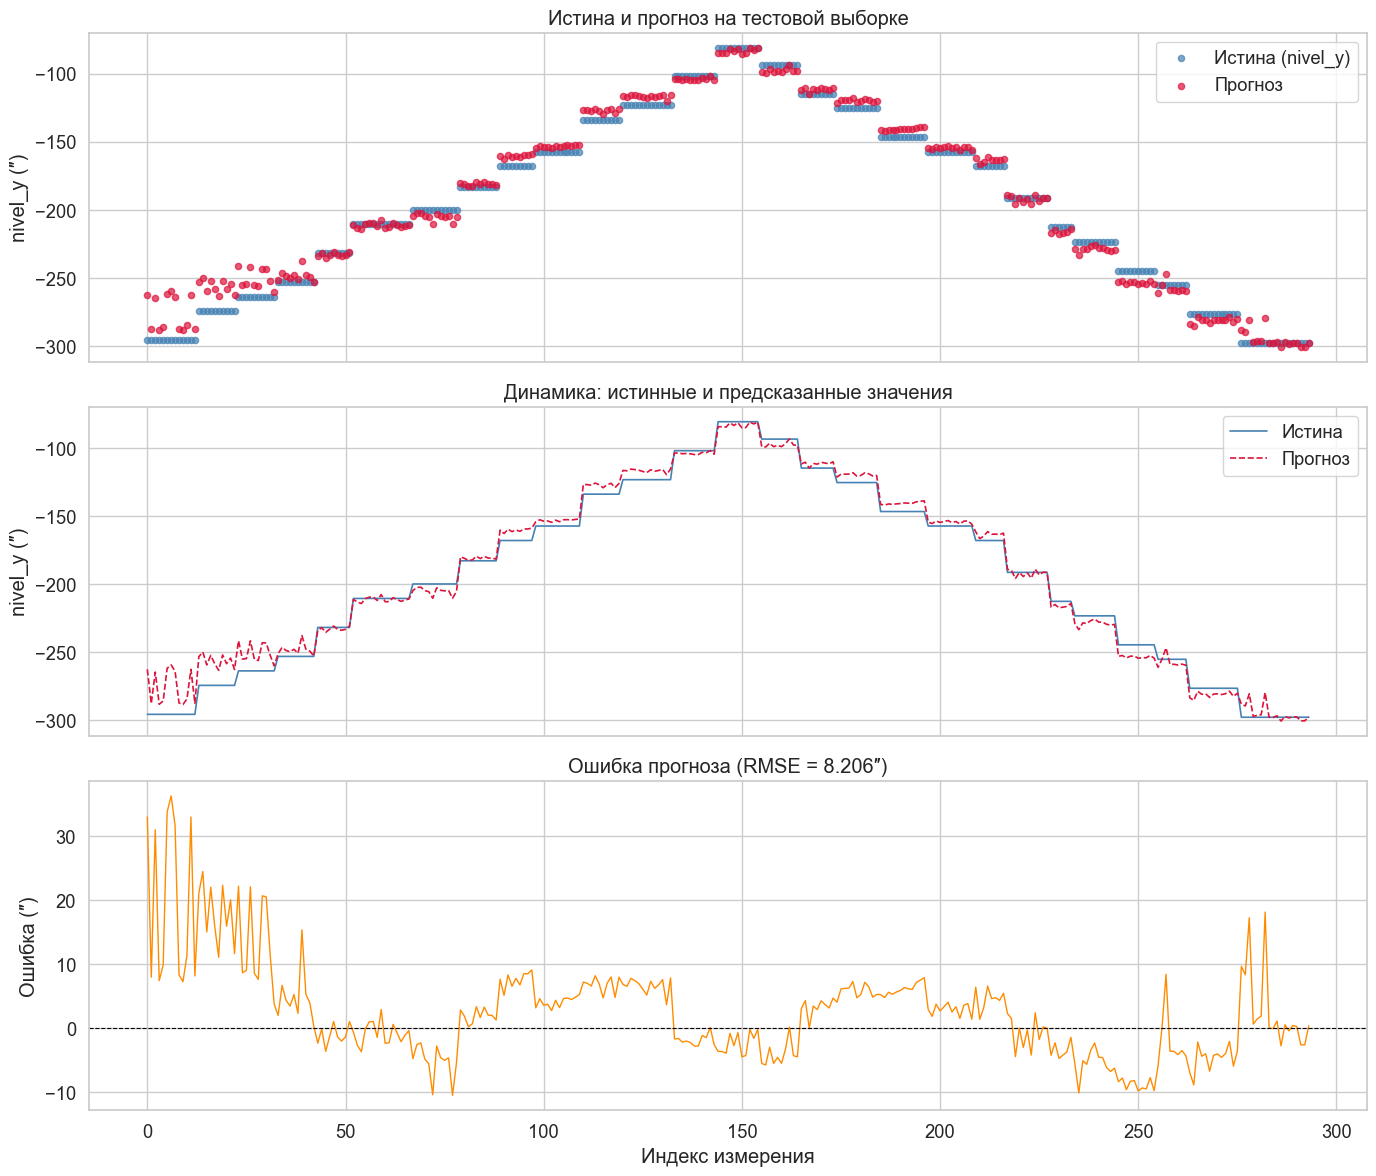

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Убедимся, что y_test и y_pred — это массивы/серии с тем же индексом
y_true = y_test.values
y_pred = final_model.predict(X_test)
errors = y_pred - y_true

# Индексы измерений (можно использовать как "время" или порядковый номер)
indices = np.arange(len(y_true))

# Настройка стиля
sns.set(style="whitegrid", font_scale=1.2)
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# 1. Истина vs Прогноз (точечный график)
ax = axes[0]
ax.scatter(indices, y_true, label='Истина (nivel_y)', alpha=0.7, s=20, color='steelblue')
ax.scatter(indices, y_pred, label='Прогноз', alpha=0.7, s=20, color='crimson')
ax.set_ylabel('nivel_y (″)')
ax.set_title('Истина и прогноз на тестовой выборке')
ax.legend()
ax.grid(True)

# 2. Временной график (линии)
ax = axes[1]
ax.plot(indices, y_true, label='Истина', linewidth=1.2, color='steelblue')
ax.plot(indices, y_pred, label='Прогноз', linewidth=1.2, color='crimson', linestyle='--')
ax.set_ylabel('nivel_y (″)')
ax.set_title('Динамика: истинные и предсказанные значения')
ax.legend()
ax.grid(True)

# 3. Ошибка (разность)
ax = axes[2]
ax.plot(indices, errors, color='darkorange', linewidth=1.0)
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_xlabel('Индекс измерения')
ax.set_ylabel('Ошибка (″)')
ax.set_title(f'Ошибка прогноза (RMSE = {np.sqrt(np.mean(errors**2)):.3f}″)')
ax.grid(True)

# Общая настройка
plt.tight_layout()
plt.show()


=== Тест нормальности ошибок ===
Тест: Shapiro–Wilk
Статистика: 0.8859
p-value: 0.000000
→ Ошибки **значимо отличаются от нормального распределения** (отвергаем H₀)


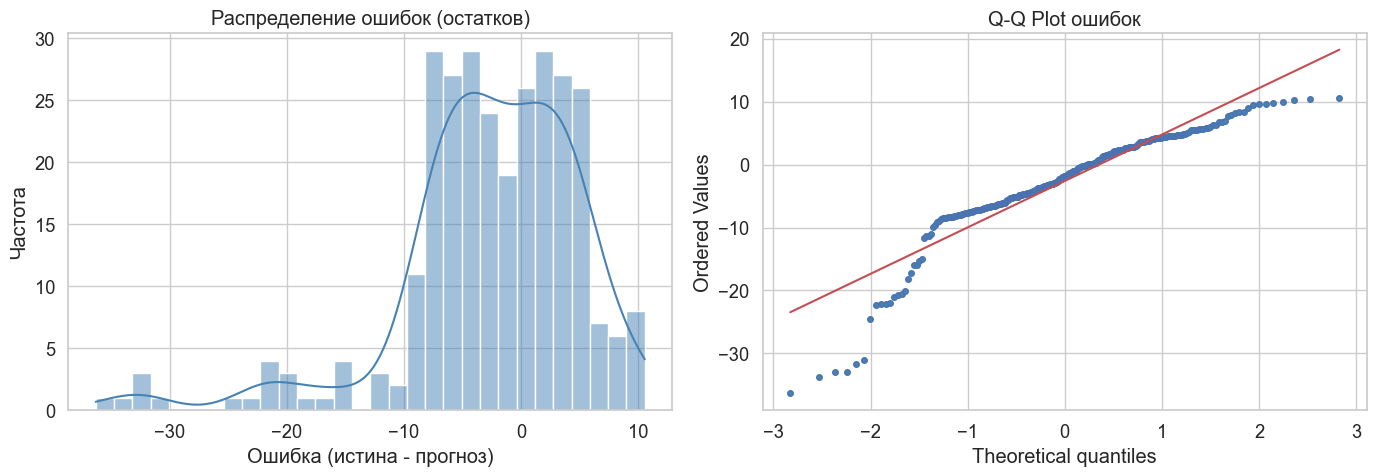

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# 1. Вычисляем ошибки
errors = y_test.values - y_pred 

# 2. Тест Шапиро–Уилка
# Внимание: тест не рекомендуется для n > 5000 (ограничение реализации)
n = len(errors)
alpha = 0.05

if n < 3:
    print("Слишком мало данных для теста Шапиро–Уилка")
elif n > 5000:
    print(f"Внимание: n = {n} > 5000. Тест Шапиро–Уилка может быть ненадёжным.")
    # Можно использовать альтернативу, например, тест D’Agostino (omnibus)
    stat, p = stats.normaltest(errors)
    test_name = "D’Agostino’s K²"
else:
    stat, p = stats.shapiro(errors)
    test_name = "Shapiro–Wilk"

print(f"\n=== Тест нормальности ошибок ===")
print(f"Тест: {test_name}")
print(f"Статистика: {stat:.4f}")
print(f"p-value: {p:.6f}")
if p > alpha:
    print("→ Ошибки неотличимы от нормального распределения (не отвергаем H₀)")
else:
    print("→ Ошибки значимо отличаются от нормального распределения (отвергаем H₀)")

# 3. Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гистограмма + KDE
sns.histplot(errors, kde=True, bins=30, color='steelblue', ax=axes[0])
axes[0].set_title('Распределение ошибок (остатков)')
axes[0].set_xlabel('Ошибка (истина - прогноз)')
axes[0].set_ylabel('Частота')

# Q-Q plot
stats.probplot(errors, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot ошибок')
axes[1].get_lines()[0].set_markerfacecolor('steelblue')
axes[1].get_lines()[0].set_markersize(4)

plt.tight_layout()
plt.show()

In [143]:
# # 1. Сохранение лучшей модели
# import joblib
# import os

# # Создаем папку для моделей если её нет
# os.makedirs('./models', exist_ok=True)

# # Сохраняем лучшую модель
# model_path = './models/best_catboost_model_400600.pkl'
# joblib.dump(final_model, model_path)
# print(f"Модель сохранена по пути: {model_path}")


In [144]:
# # model_path = './models/best_catboost_model_0200.pkl'
# model_path = './models/best_catboost_model_200400.pkl'
# # 2. Загрузка модели
# def load_and_predict(model_path, X_data):
#     """Загрузка модели и предсказание"""
#     loaded_model = joblib.load(model_path)
#     predictions = loaded_model.predict(X_data)
#     return predictions, loaded_model

# # Проверка загрузки модели
# test_predictions, loaded_model = load_and_predict(model_path, X_test)
# print(f"Проверка загрузки модели - RMSE: {np.sqrt(mean_squared_error(y_test, test_predictions)):.4f}")
# y_pred = loaded_model.predict(X_test)
# mean = np.mean(y_test - y_pred)
# mae = mean_absolute_error(y_test, test_predictions)
# std_err = np.std(test_predictions)
# rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
# r2 = r2_score(y_test, test_predictions)

# print(f"\n=== FINAL RESULTS ===")
# print(f"Test MEAN:  {mean:.4f}")
# print(f"Test MAE:  {mae:.4f}")
# print(f"Test RMSE: {rmse:.4f}")
# print(f"Test R²:   {r2:.4f}")